In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

import flickr_api
from flickr_api import Photo
from sklearn.cluster import DBSCAN

import torch

from dataset.load import LoadDataset
from dataset.utils import load_credentials
from utils.vis import make_tensor, visualize_grid

api_key, api_secret = load_credentials()
flickr_api.set_keys(api_key=api_key, api_secret=api_secret)

# Baseline: clustering using only location (lat/lon)

In [3]:
# Load dataset and count number of photos
path = "data/paris_1000_test.h5"
dataset = LoadDataset(path)
print(dataset.size(), "photos")

999 photos


In [4]:
# Get features from dataset
it = dataset.get()
X = []
for i, row in enumerate(it):
    metadata, _, embedding = row

    # Location
    lat = float(metadata["location"]["latitude"])
    lon = float(metadata["location"]["longitude"])
    
    # Tags    
    tags = " ".join([tag["text"] for tag in metadata["tags"]])

    # Embedding
    emb = embedding.tolist()

    id = int(metadata["id"])
    X.append([id, lat, lon])

X = np.asarray(X)
X.shape

(999, 3)

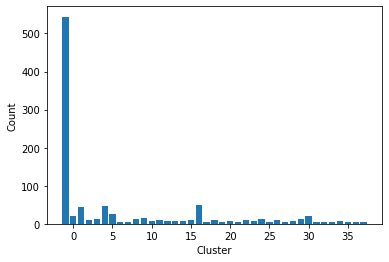

In [5]:
# Sampling on a smaller subset
X_train = X[:, 1:]

# Train clustering using DBSCAN
kms_per_radian = 6371.0088
meters = 30
epsilon = (meters * 0.001) / kms_per_radian
db = DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
db.fit(np.radians(X_train))
y_train = db.labels_

# Plot
fig, ax = plt.subplots()
ax.bar(*np.unique(y_train, return_counts=True))
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
plt.show()

In [6]:
# Get images in clusters
cluster_imgs = {}
for label in set(y_train):
    if label == -1: continue
    photos_id = X[y_train == label, 0]
    cluster_imgs[label] = []
    subset = np.random.choice(photos_id.shape[0], size=min(photos_id.shape[0], 6), replace=False)
    for photo_id in photos_id[subset]:
        _, img, _ = dataset.get_id(int(photo_id))
        cluster_imgs[label].append(img)

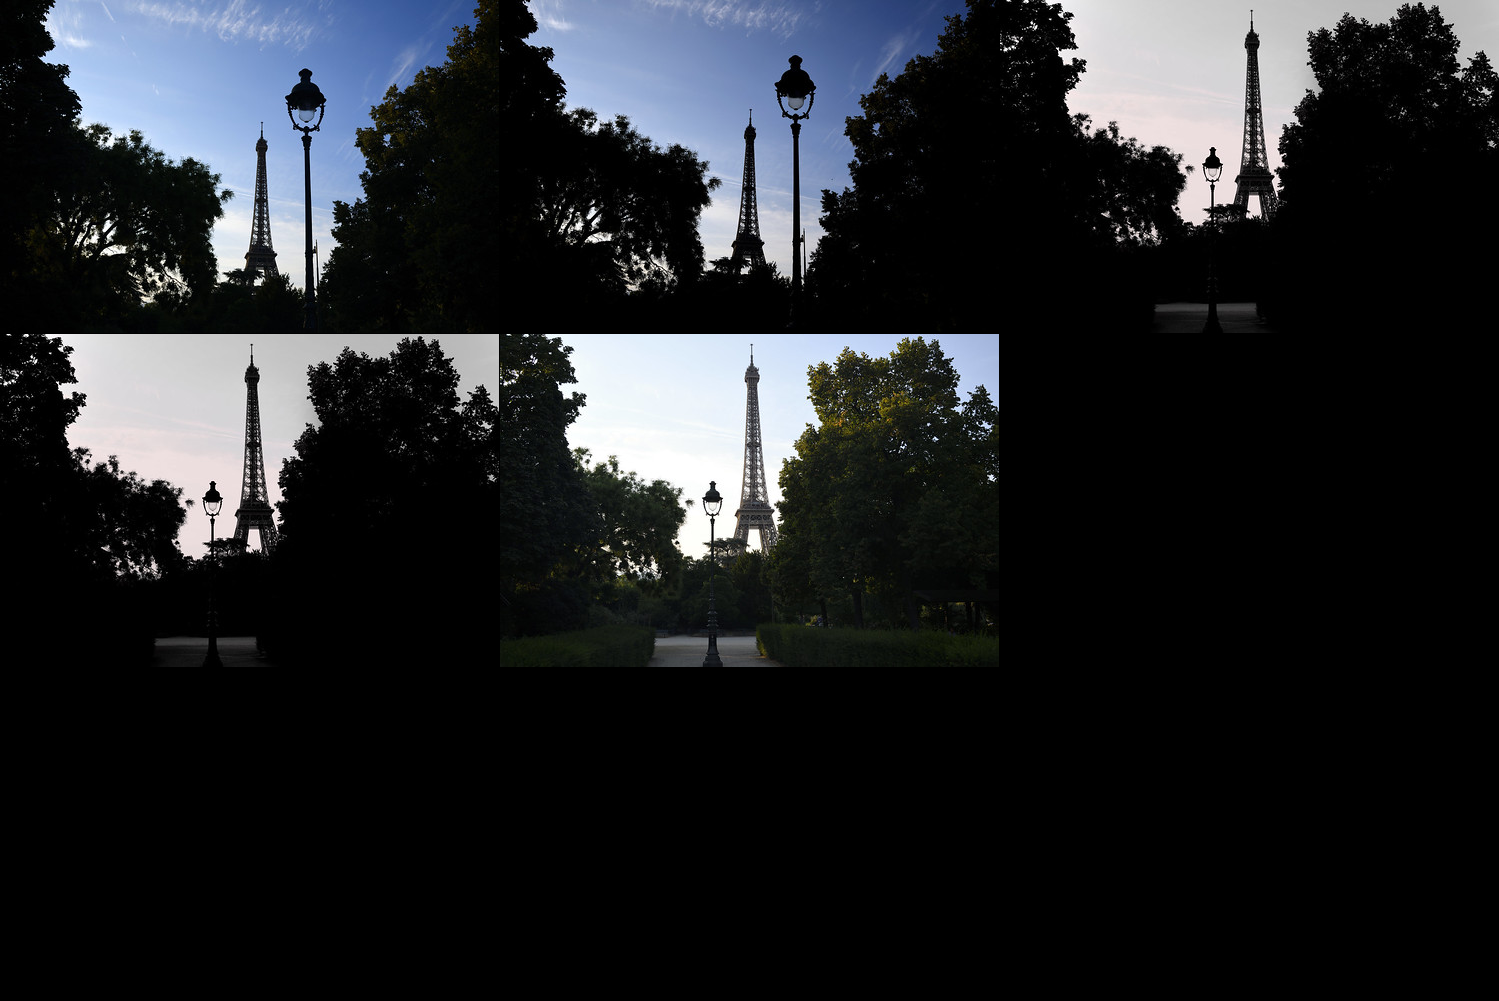

In [7]:
# Visualize photos from the same cluster
cluster_label = 33
grid = visualize_grid(make_tensor(cluster_imgs[cluster_label]))
Image.fromarray(grid.astype("uint8"))

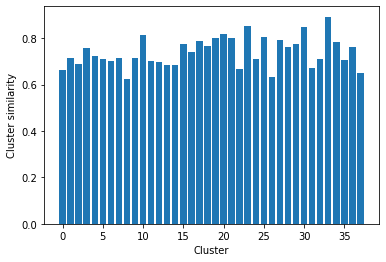

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cluster_sim(X):
    embedding_X = [dataset.get_id(int(photo_id))[2] for photo_id in X[:, 0]]
    embedding_X = np.stack(embedding_X, axis=0)
    return cosine_similarity(embedding_X).mean()

# Quantitative measure of the clusters
cluster_similarities = {}
for label in set(y_train):
    if label == -1: continue
    cluster_X = X[y_train == label]
    cluster_sim = compute_cluster_sim(cluster_X)
    cluster_similarities[label] = cluster_sim

# Plot
fig, ax = plt.subplots()
ax.bar(cluster_similarities.keys(), [cluster_similarities[k] for k in cluster_similarities.keys()])
ax.set_xlabel("Cluster")
ax.set_ylabel("Cluster similarity")
plt.show()

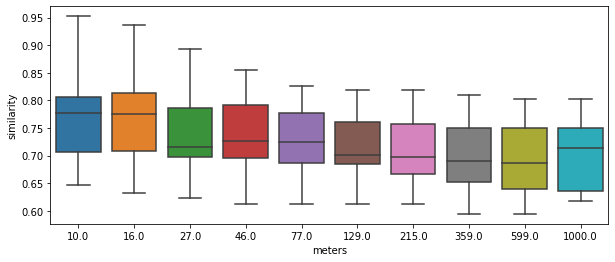

In [9]:
def plot_distance_vs_sim(X):
    df = pd.DataFrame()
    for meters in np.logspace(1, 3, num=10):
        X_train = X[:, 1:]

        # Train clustering using DBSCAN
        kms_per_radian = 6371.0088
        epsilon = (int(meters) * 0.001) / kms_per_radian
        db = DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
        db.fit(np.radians(X_train))
        y_train = db.labels_

        # Similarities
        for label in set(y_train):
            if label == -1: continue
            cluster_X = X[y_train == label]
            cluster_sim = compute_cluster_sim(cluster_X)
            df = df.append({
                "meters": int(meters),
                "similarity": cluster_sim
            }, ignore_index=True)
        
    return df

exp_meters = plot_distance_vs_sim(X)
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(x="meters", y="similarity", data=exp_meters, ax=ax)
plt.show()

# Multifeature DBSCAN

In [12]:
from clustering.dbscan import MultiFeatureDBSCAN
from clustering.embedding import WSL, VGG16

params = {
    "dataset": LoadDataset("./data/paris_1000.h5"),
    "model": VGG16(-5),
    "weights": (0.33, 0.33, 1-2*0.33),
    #"weights": (0.5, 0.5, 0.0),
    #"weights": (1.0, 0.0, 0.0),
    "max_data": 500,
    "eps": 0.13,
    "min_samples": 2
}
model = MultiFeatureDBSCAN(**params)
model.fit()

Get data from hdfs5 file...
Images to embeddings...
Vectorization of tags...
Final training set: (500, 2) (500, 500) (500, 500)
Compute distance matrix of locations...
Compute distance matrix of embeddings...
Compute distance matrix of tags...
dist_matrix: 0.0 0.4960548678552854+-0.09064534362819504 0.8099350262939938
Training DBSCAN...
Result: 40 clusters
Counts: 2 5.425+-5.598604736896506 24


Silhouette 0.0374985674734292, Calinski 15.618704960953517


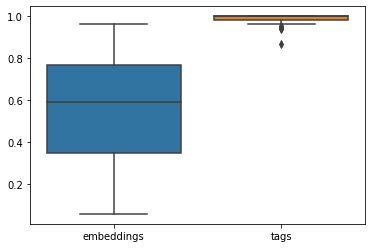

In [13]:
metrics = model.results()
print(f"Silhouette {metrics['sil']}, Calinski {metrics['cha']}")
df = pd.DataFrame({
    "embeddings": [metrics["embeddings_sims"][l] for l in metrics["embeddings_sims"].keys()],
    "tags": [metrics["tags_sims"][l] for l in metrics["tags_sims"].keys()]
})
sns.boxplot(data=df)

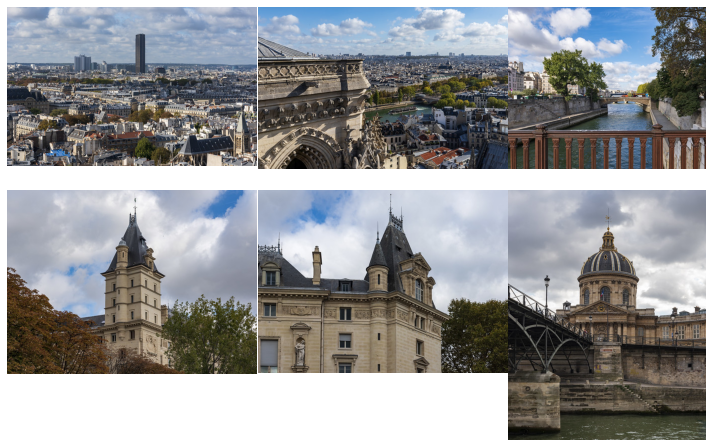

Embeddings sim: 0.2284114956855774, Tags sim: 1.0000000000000002


In [14]:
from utils.vis import thumb_grid

# Get images in clusters
cluster_imgs = {}
for label in set(model.labels):
    if label == -1: continue
    photos_id = [model.idx[i] for i in range(model.labels.shape[0]) if model.labels[i] == label]
    cluster_imgs[label] = []
    subset = np.random.choice(len(photos_id), size=min(len(photos_id), 6), replace=False)
    for photo_id in [photos_id[i] for i in subset]:
        _, img, _ = params["dataset"].get_id(int(photo_id))
        cluster_imgs[label].append(img)

# Visualize photos from the same cluster
cluster_label = 15
fig = thumb_grid(cluster_imgs[cluster_label], (2, 3))
fig.set_size_inches(10, 10)
fig.tight_layout()
plt.show()
print(f"Embeddings sim: {metrics['embeddings_sims'][cluster_label]}, Tags sim: {metrics['tags_sims'][cluster_label]}")

In [15]:
from utils.geojson import GeoJson

# Build GeoJSON
df = pd.DataFrame()
for label in set(model.labels):
    if label == -1: continue
    photos_id = [model.idx[i] for i in range(model.labels.shape[0]) if model.labels[i] == label]
    for photo_id in photos_id:
        metadata, _, _ = params["dataset"].get_id(int(photo_id))
        df = df.append({
            "id": metadata["id"],
            "cluster": int(label),
            "lat": float(metadata["location"]["latitude"]),
            "lon": float(metadata["location"]["longitude"]),
            "title": str(metadata["title"]) if ("title" in metadata.keys() and metadata["title"] != "") else "(No title)",
            "url": metadata["photo_file_urls"]["Small"],
            "urls": metadata["photo_file_urls"],
            "tags": [t["text"] for t in metadata["tags"]],
            "aesthetic_score": metadata["aesthetic_score"]
        }, ignore_index=True)

# Export GeoJSON
geojson_data = GeoJson().to_geojson(df, 
    'cluster', # column for grouping to the same pin color
    'lat', # latitude column name
    'lon', # longitude column name
    [c for c in df.columns], # metadata to add in the geojson,
)
geojson_data.save_to("geojson-viewer/data.geojson")
df.head()

,aesthetic_score,cluster,id,lat,lon,tags,title,url,urls
0,5.273218,0.0,28277813277,48.771407,2.265157,"[nature, paysage, landscape, landscapes, dream...",Verte prairie,https://live.staticflickr.com/1827/28277813277...,{'Square': 'https://live.staticflickr.com/1827...
1,4.994539,0.0,41295576510,48.774971,2.263183,"[nature, paysage, landscape, landscapes, dream...",S,https://live.staticflickr.com/1810/41295576510...,{'Square': 'https://live.staticflickr.com/1810...
2,4.681994,1.0,28587621467,48.827567,2.348327,"[paris, street, art, france, ville, de, île, a...",Paris street art,https://live.staticflickr.com/1806/28587621467...,{'Square': 'https://live.staticflickr.com/1806...
3,4.399861,1.0,29604682708,48.827567,2.348327,"[ville, de, île, architecture, paris, 75, fran...","H. Lefevre, fabricant de chaussures et de galo...",https://live.staticflickr.com/1824/29604682708...,{'Square': 'https://live.staticflickr.com/1824...
4,4.478337,1.0,42569632555,48.827567,2.348327,"[paris, street, art, france, ville, de, île, a...",Paris street art,https://live.staticflickr.com/835/42569632555_...,{'Square': 'https://live.staticflickr.com/835/...


# Grid Search

In [185]:
cnn_model = VGG16(-5)
dataset = LoadDataset("./data/paris_1000_test.h5")
max_data = 500

In [186]:
from itertools import product

grid_params = [
    {"dataset": dataset, "model": cnn_model, "weights": (1.0, 0.0, 0.0), "max_data": max_data, "verbose": False},
    {"dataset": dataset, "model": cnn_model, "weights": (0.33, 0.33, 1-2*0.33), "max_data": max_data, "verbose": False}
]

results = pd.DataFrame()
search_space = list(product(grid_params, np.arange(0.01, 0.20, 0.02), np.arange(2, 10, 1)))
print(f"Experiments: {len(search_space)}")
for i, candidate in enumerate(search_space):
    if i % 10 == 0: print(f"{i}/{len(search_space)}...")
    params, eps, min_samples = candidate
    params.update({"eps": eps, "min_samples": min_samples})
    model = MultiFeatureDBSCAN(**params)
    model.fit()
    metrics = model.results()
    metrics.update(params)
    results = results.append(metrics, ignore_index=True)

print("done")
results = results.drop(["dataset", "model"], axis=1)
results.sample(n=min(3, results.shape[0]))

Experiments: 160
0/160...
10/160...
20/160...
30/160...
40/160...
50/160...
60/160...
70/160...
80/160...
90/160...
100/160...
110/160...
120/160...
130/160...
140/160...
150/160...
done


,cha,embeddings_sims,eps,max_data,min_samples,n_clusters,sil,tags_sims,verbose,weights
96,2.612524,"{0: 0.96394384, 1: 0.91569924, 2: 0.9999747, 3...",0.05,500.0,2.0,6.0,-0.076241,"{0: 1.0000000000000002, 1: 1.0, 2: 0.941469055...",0.0,"(0.33, 0.33, 0.33999999999999997)"
107,NaN,{},0.07,500.0,5.0,0.0,NaN,{},0.0,"(0.33, 0.33, 0.33999999999999997)"
82,NaN,{},0.01,500.0,4.0,0.0,NaN,{},0.0,"(0.33, 0.33, 0.33999999999999997)"


In [9]:
results["embeddings_sims_mean"] = results["embeddings_sims"].apply(lambda sims: np.mean([v for _,v in sims.items()]))
results["tags_sims_mean"] = results["tags_sims"].apply(lambda sims: np.mean([v for _,v in sims.items()]))

best = results\
    .sort_values(by=["n_clusters", "sil", "embeddings_sims_mean", "tags_sims_mean"], ascending=False)\
    .groupby("weights").head(1)
best[["weights", "eps", "min_samples", "embeddings_sims_mean", "tags_sims_mean", "sil", "n_clusters"]]

NameError: name 'results' is not defined

In [232]:
results[results["weights"] == (0.33, 0.33, 0.33999999999999997)]\
    .sort_values(by=["n_clusters", "sil", "embeddings_sims_mean", "tags_sims_mean"], ascending=False)\
    [["weights", "eps", "min_samples", "embeddings_sims_mean", "tags_sims_mean", "sil", "n_clusters"]].head(30)

,weights,eps,min_samples,embeddings_sims_mean,tags_sims_mean,sil,n_clusters
152,"(0.33, 0.33, 0.33999999999999997)",0.19,2.0,0.461648,0.943423,0.194727,46.0
128,"(0.33, 0.33, 0.33999999999999997)",0.13,2.0,0.549371,0.986708,0.037499,40.0
136,"(0.33, 0.33, 0.33999999999999997)",0.15,2.0,0.470248,0.974976,0.116177,39.0
144,"(0.33, 0.33, 0.33999999999999997)",0.17,2.0,0.456318,0.957974,0.169901,38.0
120,"(0.33, 0.33, 0.33999999999999997)",0.11,2.0,0.650021,0.995475,-0.098276,34.0
153,"(0.33, 0.33, 0.33999999999999997)",0.19,3.0,0.311395,0.935238,0.174546,25.0
137,"(0.33, 0.33, 0.33999999999999997)",0.15,3.0,0.322304,0.979511,0.107086,24.0
145,"(0.33, 0.33, 0.33999999999999997)",0.17,3.0,0.297564,0.955399,0.150137,23.0
129,"(0.33, 0.33, 0.33999999999999997)",0.13,3.0,0.424435,0.985212,0.043224,22.0
146,"(0.33, 0.33, 0.33999999999999997)",0.17,4.0,0.276398,0.955668,0.153260,21.0
